# pytorch

In [1]:
"""
Reference:
    https://github.com/yformer/EfficientSAM/blob/main/EfficientSAM_example.py
"""
from efficient_sam.build_efficient_sam import build_efficient_sam_vits

from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import zipfile
device = "cpu"
model = build_efficient_sam_vits()
sample_image_np = np.array(Image.open("./figs/examples/dogs.jpg"))
sample_image_tensor = transforms.ToTensor()(sample_image_np)
input_points = torch.tensor([[[[580, 350], [650, 350]]]])
input_labels = torch.tensor([[[1, 1]]])
predicted_logits_torch, predicted_iou_torch = model(sample_image_tensor[None, ...], input_points, input_labels)

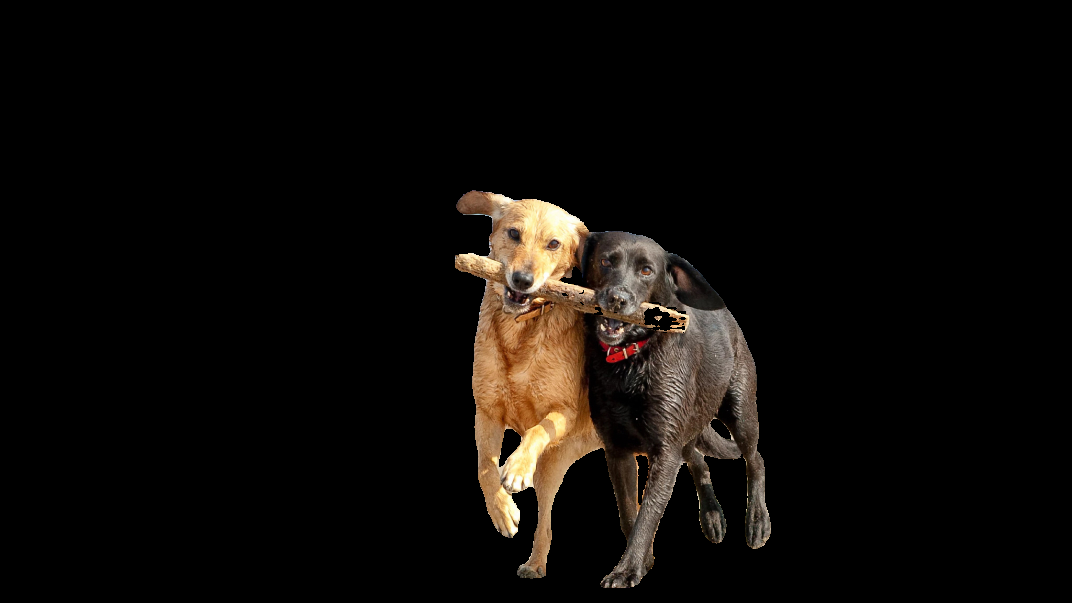

In [2]:
sorted_ids = torch.argsort(predicted_iou_torch, dim=-1, descending=True)
predicted_iou_torch = torch.take_along_dim(predicted_iou_torch, sorted_ids, dim=2)
predicted_logits = torch.take_along_dim(
    predicted_logits_torch, sorted_ids[..., None, None], dim=2
)

mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()
masked_image_np = sample_image_np.copy().astype(np.uint8) * mask[:,:,None]
Image.fromarray(masked_image_np)

In [3]:
"""
generate image embedding from torch model so tensorflow model(sam decoder) can use image embedding as input
"""
from torchvision.transforms import ToTensor
img = ToTensor()(sample_image_np).to(device)
img_embeddings = model.get_image_embeddings(img[None, ...]).tolist()

# tensorflow

In [4]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle

saved_model_path = './saved_model'
model = tf.saved_model.load(saved_model_path)
infer = model.signatures["serving_default"]
sample_image_np = np.array(Image.open("./figs/examples/dogs.jpg"))
sample_image_tensor = tf.convert_to_tensor(sample_image_np, dtype=tf.float32)
sample_image_tensor = tf.expand_dims(sample_image_tensor, axis=0)
input_points = tf.expand_dims(tf.expand_dims(tf.constant([[580, 350], [650, 350]], dtype=tf.float32), 0), 0)
input_labels = tf.expand_dims(tf.expand_dims(tf.constant([1, 1], dtype=tf.float32), 0), 0)
orig_im_size = tf.constant([sample_image_np.shape[0], sample_image_np.shape[1]], dtype=tf.int64)

results = infer(
    image_embeddings=img_embeddings, # use this value from the torch model encoder embedding
    batched_point_coords=input_points,
    batched_point_labels=input_labels,
    orig_im_size=orig_im_size
)

2024-04-02 16:42:10.649078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 16:42:11.216297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-02 16:42:12.799728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-02 16:42:12.818098: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [5]:
predicted_logits_tf = results["output_masks"].numpy()
predicted_iou_tf = results["iou_predictions"].numpy()

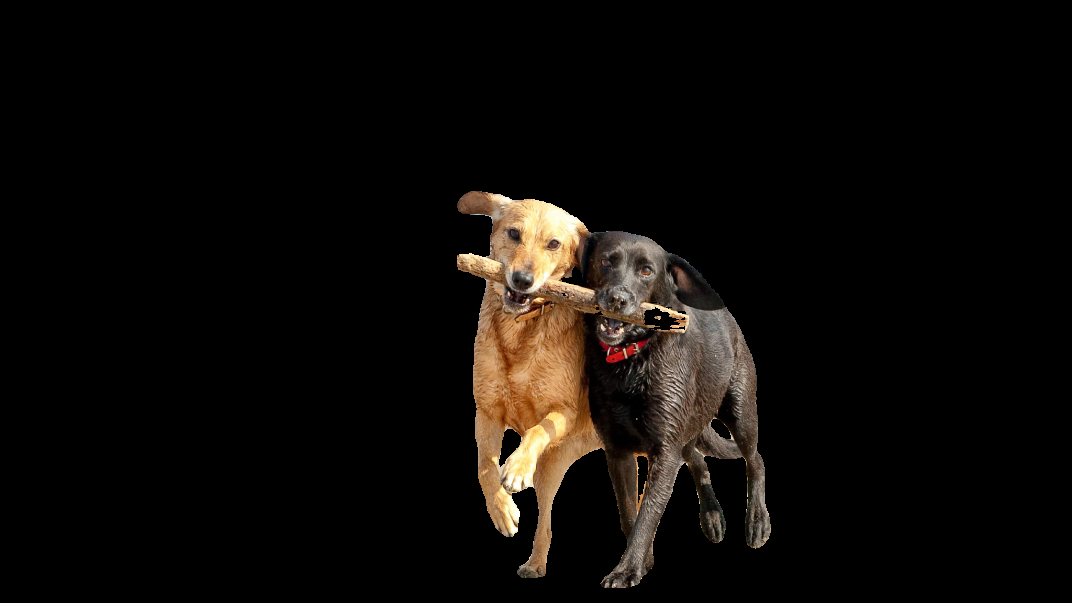

In [6]:
sorted_ids = tf.nn.top_k(predicted_iou_tf, k=predicted_iou_tf.shape[2]).indices
predicted_iou = tf.gather(predicted_iou_tf, sorted_ids, axis=2)
sorted_ids_expanded = tf.expand_dims(tf.expand_dims(sorted_ids, axis=-1), axis=-1)
tmp = tf.squeeze(tf.gather(predicted_logits_tf, sorted_ids_expanded, axis=2))
sorted_predicted_logits = tf.expand_dims(tf.expand_dims(tmp, axis=0), axis=0)
mask = tf.greater_equal(sorted_predicted_logits[0, 0, 0, :, :], 0)
masked_image_np = tf.cast(sample_image_np, tf.uint8) * tf.cast(mask[:, :, tf.newaxis], tf.uint8)

Image.fromarray(np.array(masked_image_np))